In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim 
from torchvision import datasets , transforms

In [2]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [3]:
def image_to_vec(image):
    return image.view(image.shape[0] , 784)
def vec_to_image(image):
    return image.view(image.shape[0] , 1 , 28 , 28)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784 , 128)
        self.fc2 = nn.LeakyReLU(0.2)
        self.fc3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(128 , 1)
        
    def forward(self , x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.sigmoid(self.fc4(x))
        return x

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100 , 128)
        self.fc2 = nn.LeakyReLU(0.2)
        self.fc3 = nn.Linear(128 , 64)
        self.fc4 = nn.LeakyReLU(0.2)
        self.fc5 = nn.Linear(64 , 784)
        
    def forward(self , x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.tanh(self.fc5(self.fc4(x)))
        return x

In [6]:
def noise(size):
    return torch.randn((size , 100))

In [7]:
discriminator , generator = Discriminator() , Generator()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [8]:
criterion = nn.BCELoss()

In [9]:
def target_vals(size):
    return torch.ones(size , 1) , torch.zeros(size , 1)

In [10]:
def train_discriminator(optimizer , real_labels , fake_label , real_images , fake_images):
    optimizer.zero_grad()
    
    pred = discriminator(real_images)
    loss_disc_real = criterion(pred , real_labels)
    loss_disc_real.backward()
    
    pred_fake = discriminator(fake_images)
    loss_disc_fake = criterion(pred_fake , fake_labels)
    loss_disc_fake.backward()
    
    optimizer.step()
    return loss_disc_real + loss_disc_fake

In [11]:
def train_generator(optimizer , fake_data , fake_labels):
    
    optimizer.zero_grad()
    loss = criterion(discriminator(generator(fake_data)) , fake_labels)
    loss.backward()
    optimizer.step()
    return loss

In [12]:
generator(noise(100)).shape

torch.Size([100, 784])

In [13]:
for epoch in range(1 , 100):
    for batch , (images , _) in enumerate(data_loader):
        
        N = images.shape[0]
        train_data = image_to_vec(images)
        fake_data = noise(N)
        real_labels , fake_labels = target_vals(N)
        
        d_loss = train_discriminator(d_optimizer , real_labels , fake_labels , train_data , generator(fake_data))
        g_loss = train_generator(g_optimizer , fake_data , real_labels)
    print('epoch ' , epoch , 'generator loss ' , str(g_loss) , 'discriminator loss ', str(d_loss))
        

epoch  1 generator loss  tensor(0.8508, grad_fn=<BinaryCrossEntropyBackward>) discriminator loss  tensor(0.8628, grad_fn=<AddBackward0>)
epoch  2 generator loss  tensor(1.0729, grad_fn=<BinaryCrossEntropyBackward>) discriminator loss  tensor(0.9015, grad_fn=<AddBackward0>)
epoch  3 generator loss  tensor(0.9488, grad_fn=<BinaryCrossEntropyBackward>) discriminator loss  tensor(1.0301, grad_fn=<AddBackward0>)
epoch  4 generator loss  tensor(1.2277, grad_fn=<BinaryCrossEntropyBackward>) discriminator loss  tensor(0.6899, grad_fn=<AddBackward0>)
epoch  5 generator loss  tensor(1.4518, grad_fn=<BinaryCrossEntropyBackward>) discriminator loss  tensor(0.5941, grad_fn=<AddBackward0>)
epoch  6 generator loss  tensor(1.4157, grad_fn=<BinaryCrossEntropyBackward>) discriminator loss  tensor(0.7151, grad_fn=<AddBackward0>)
epoch  7 generator loss  tensor(1.6604, grad_fn=<BinaryCrossEntropyBackward>) discriminator loss  tensor(0.6775, grad_fn=<AddBackward0>)
epoch  8 generator loss  tensor(1.4045, g

epoch  61 generator loss  tensor(1.2735, grad_fn=<BinaryCrossEntropyBackward>) discriminator loss  tensor(1.1414, grad_fn=<AddBackward0>)
epoch  62 generator loss  tensor(1.2237, grad_fn=<BinaryCrossEntropyBackward>) discriminator loss  tensor(0.9456, grad_fn=<AddBackward0>)
epoch  63 generator loss  tensor(1.3002, grad_fn=<BinaryCrossEntropyBackward>) discriminator loss  tensor(1.0725, grad_fn=<AddBackward0>)
epoch  64 generator loss  tensor(1.3041, grad_fn=<BinaryCrossEntropyBackward>) discriminator loss  tensor(1.0089, grad_fn=<AddBackward0>)
epoch  65 generator loss  tensor(1.3354, grad_fn=<BinaryCrossEntropyBackward>) discriminator loss  tensor(1.1957, grad_fn=<AddBackward0>)
epoch  66 generator loss  tensor(1.2414, grad_fn=<BinaryCrossEntropyBackward>) discriminator loss  tensor(1.0888, grad_fn=<AddBackward0>)
epoch  67 generator loss  tensor(1.1959, grad_fn=<BinaryCrossEntropyBackward>) discriminator loss  tensor(1.1185, grad_fn=<AddBackward0>)
epoch  68 generator loss  tensor(1

In [14]:
import matplotlib.pyplot as plt
latent_layer = noise(20)
images_final = generator(latent_layer)


In [15]:
arr = images_final.detach().numpy()

In [16]:
arr = vec_to_image(images_final)

In [17]:
final_arr = arr.detach().numpy()

In [18]:
final_arr.shape

(20, 1, 28, 28)

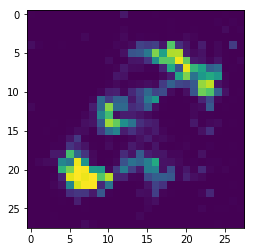

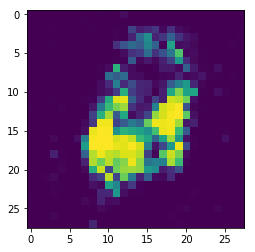

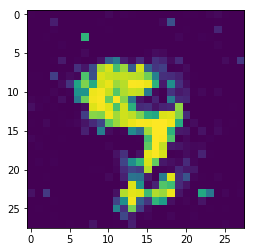

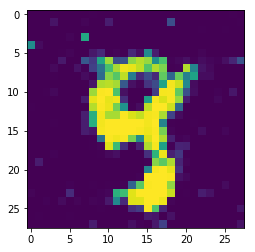

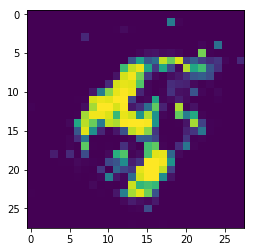

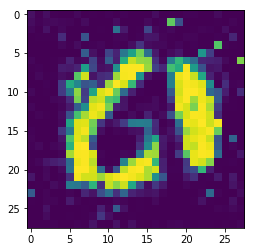

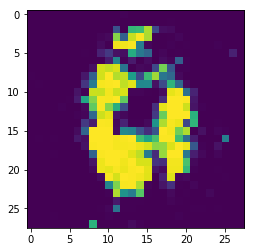

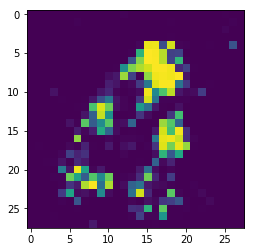

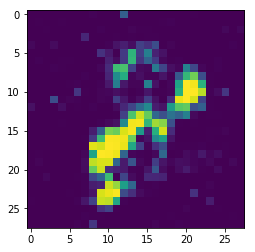

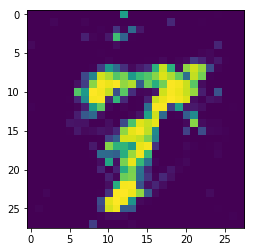

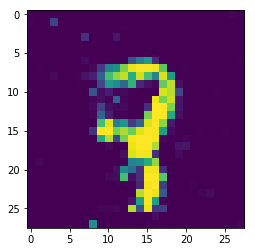

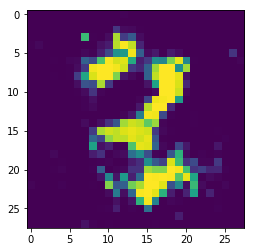

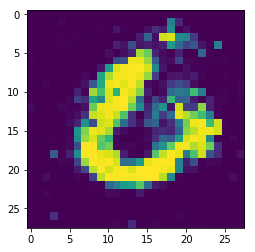

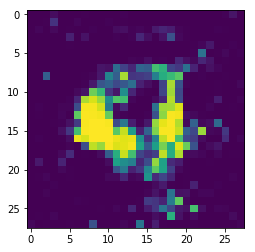

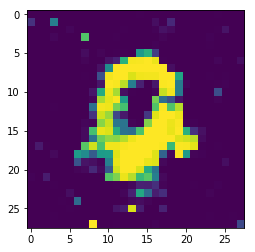

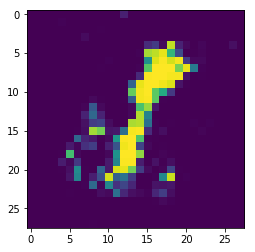

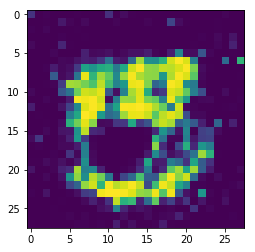

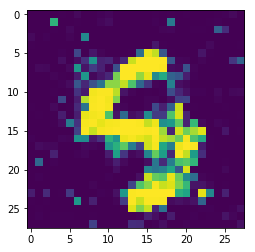

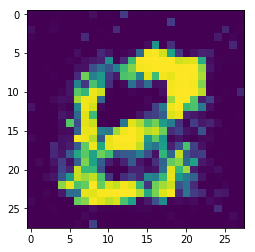

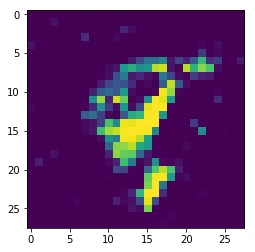

In [19]:
for array in final_arr: 
    plt.imshow(array.reshape(28,28))
    plt.show()

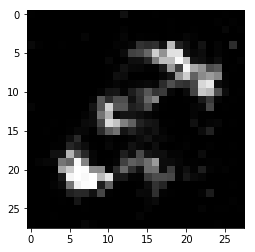

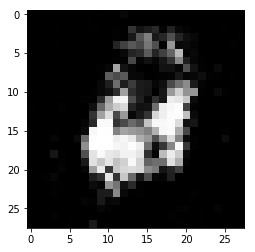

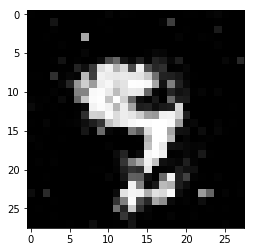

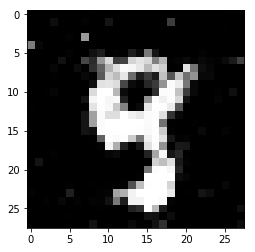

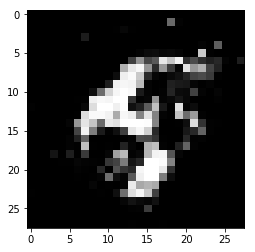

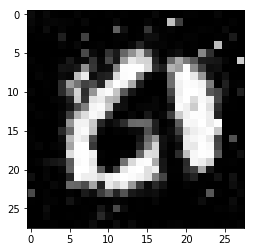

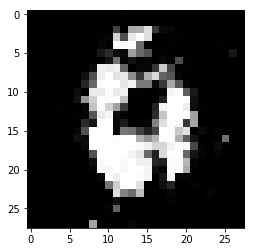

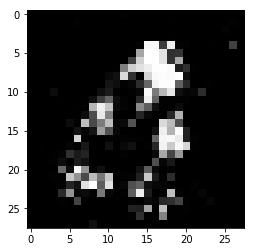

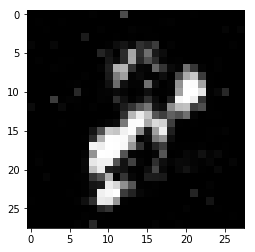

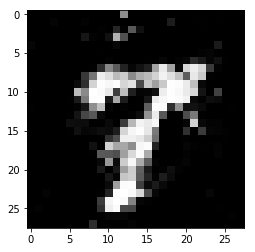

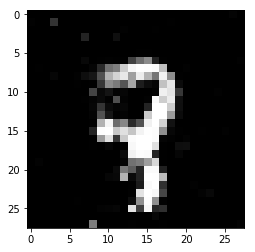

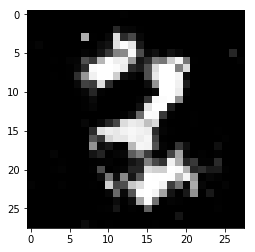

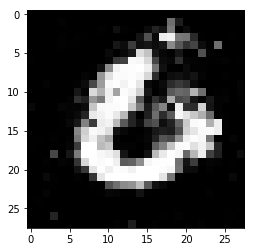

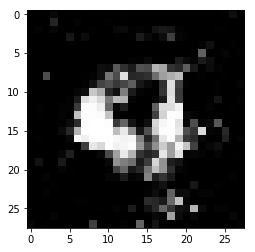

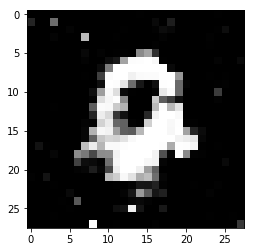

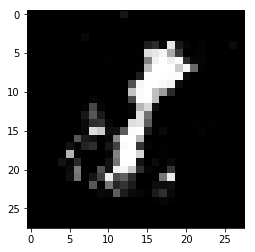

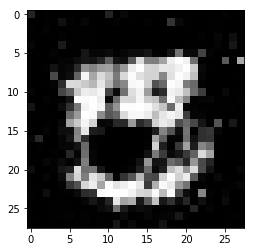

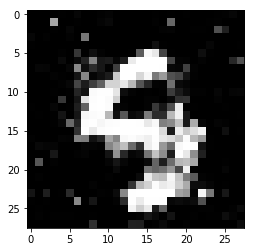

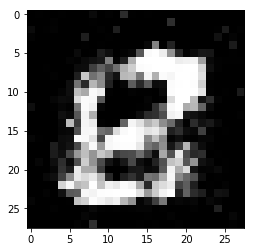

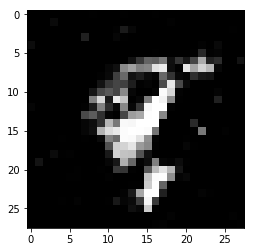

In [20]:
for array in final_arr: 
    plt.imshow(array.reshape(28,28) , cmap = 'gray')
    plt.show()